# IE 582 Statistical Learning for Data Mining
## Homework 1
**Date:** *15-11-2024*  
**School Number:** *2023072075*  
**Name:** *Yusuf Sina Öztürk*

#### Setup
- Need to import all libraries where I will use each of in different part of the homework.
- Read provided datasets.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import json
from ydata_profiling import ProfileReport
from ydata_profiling.utils.cache import cache_file

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
import lightgbm as lgb

/home/jovyan/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jovyan/.local/lib/python3.11/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
S11_img = pd.read_csv('hw1_img.csv')
S11_real = pd.read_csv('hw1_real.csv')
features = pd.read_csv('hw1_input.csv')

#### Preparation of Data
- I need to identify the frequency where the antenna performs most efficiently, meaning the maximum amount of power is transmitted and the reflection is minimized. Because antennas are typically tuned to operate effectively at specific frequencies, in this problem it is enough to get minimum S11 parameter for each anttenna design.

In [3]:
S11_img = S11_img.apply(pd.to_numeric, errors='coerce') #Make the dataset all numeric value
S11_real = S11_real.apply(pd.to_numeric, errors='coerce')

In [4]:
S11_img['img_min_freq_S11'] = S11_img.min(axis=1) #Find the lowest S11 value for each antenna design
S11_img['img_min_freq'] = S11_img.idxmin(axis=1) #Find frequency that has the lowest S11 value for each antenna design

S11_real['real_min_freq_S11'] = S11_real.min(axis=1)
S11_real['real_min_freq'] = S11_real.idxmin(axis=1)

- Because I focused on using geometric features that provided on input dataset, I can merge output values for each design with geometric features

In [5]:
data = pd.concat([features, S11_img['img_min_freq_S11'], S11_img['img_min_freq'], S11_real['real_min_freq_S11'], S11_real['real_min_freq']], axis=1)

#### Explatory Data Analysis

- In order to chech what is the properties of my dataset, I have used compact `ydata_profiling` library to check each column of my set with respect to their statistical values.
- The function that used below created an HTML file, it is also included in repository.

In [7]:
%%time
report = ProfileReport(data, title="HW1_EDA", minimal=True)
report.to_file("HW1_EDA.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

CPU times: user 11.3 s, sys: 6.39 s, total: 17.7 s
Wall time: 7.01 s


- With checking the statistical properties of my dataset, there are no outliers or NA values in my set, so we can continue without doing any preprocesses on dataset.
- Because we will continue with PCA Analysis, we should check here that each feature are on the same scale. Turns out that each one of them has their own scale. That is why it is important to do standardization.

### Q3.1 - PCA Analysis

#### Feature Distributions
- As we know, even it is not required to run PCA if the features are not in the same scale or normally distributed, PCA can perform better if it scaled at the same range with same variance. That is why, I have checked features distributions whether it is closely distributed as normal or not with Q-Q plot.
- Quantile-Quantile (Q-Q) Plot is try to visualize that data is distributed like choosen distribution or not. If the datapoints are located on the red line, that means data is distributed as choosen distribution

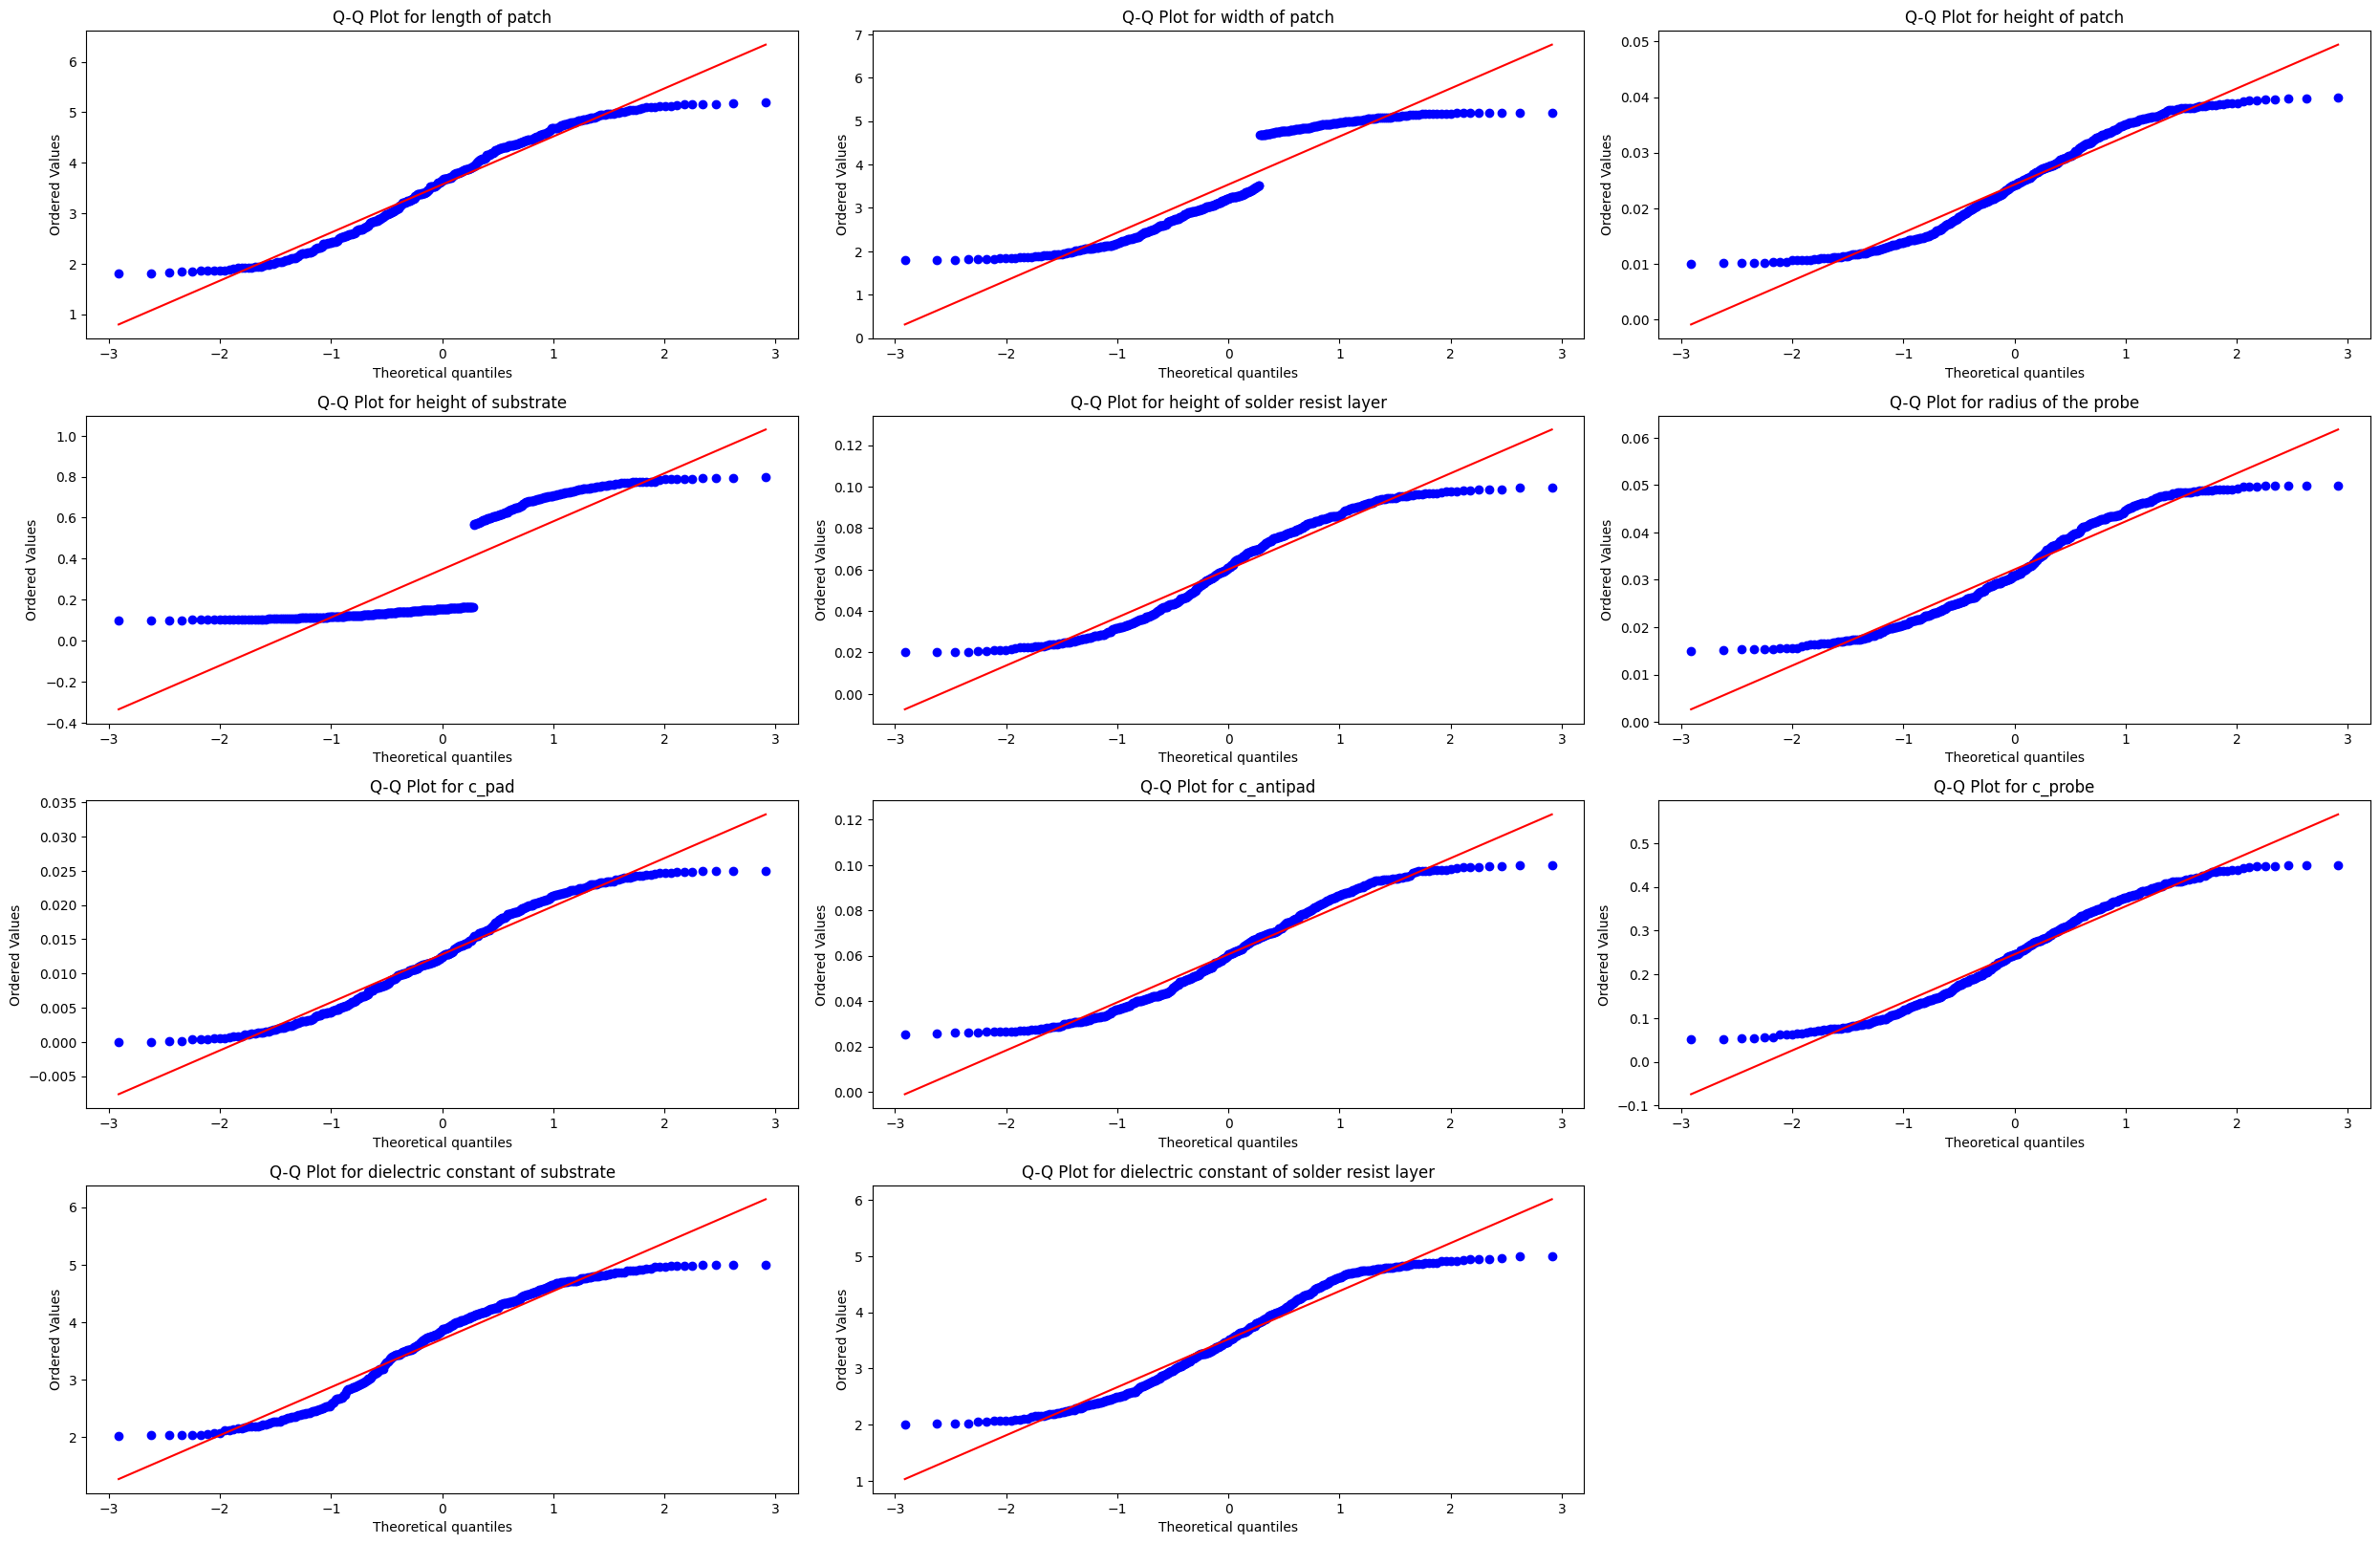

In [6]:
feature_names = features.columns
plt.figure(figsize=(25, len(feature_names)*4))

# Create plot for each geometric feature in our dataset
for i, feature in enumerate(feature_names, 1):
    plt.subplot(len(feature_names), 3, i)
    stats.probplot(features[feature], dist="norm", plot=plt)  # Choosen distribution is Normal
    plt.title(f'Q-Q Plot for {feature}')

plt.tight_layout()
plt.show()

- We can see from above plots that non of the feature normally distributed, because data points does not create a straight line on any feature
- Also as we can see on Explatory Data Anaylsis, features are not in the same scale, we probably need to do standardization.
- Below I perform 2 PCA with standardized and non standardized dataset

#### PCA with Non Standardized Data

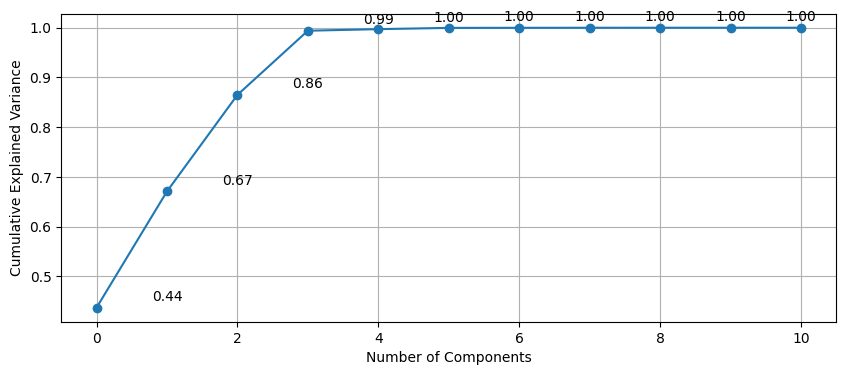

Cumulative Variances: [0.43715489 0.67092977 0.86495968 0.99398017 0.99713316 0.99968217
 0.99982509 0.99994072 0.99996786 0.99998718 1.        ]


In [7]:
X = data.drop(columns=['img_min_freq_S11', 'img_min_freq', 'real_min_freq_S11', 'real_min_freq'])
y_real = data['real_min_freq_S11']
y_img = data['img_min_freq_S11']

pca = PCA()
pca.fit(X)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 4))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
for i, value in enumerate(cumulative_variance):
    plt.annotate(f"{value:.2f}", (i + 1, value), textcoords="offset points", xytext=(0, 5), ha='center')
plt.show()

print("Cumulative Variances:", cumulative_variance)

- With checking cumulative variances, 99% of total variance can be represented by 4 components of PCA
- As we can see from the cumulative variances, with 4 components of PCA we can reach enough information. We will continue with using first 4 components of our PCA

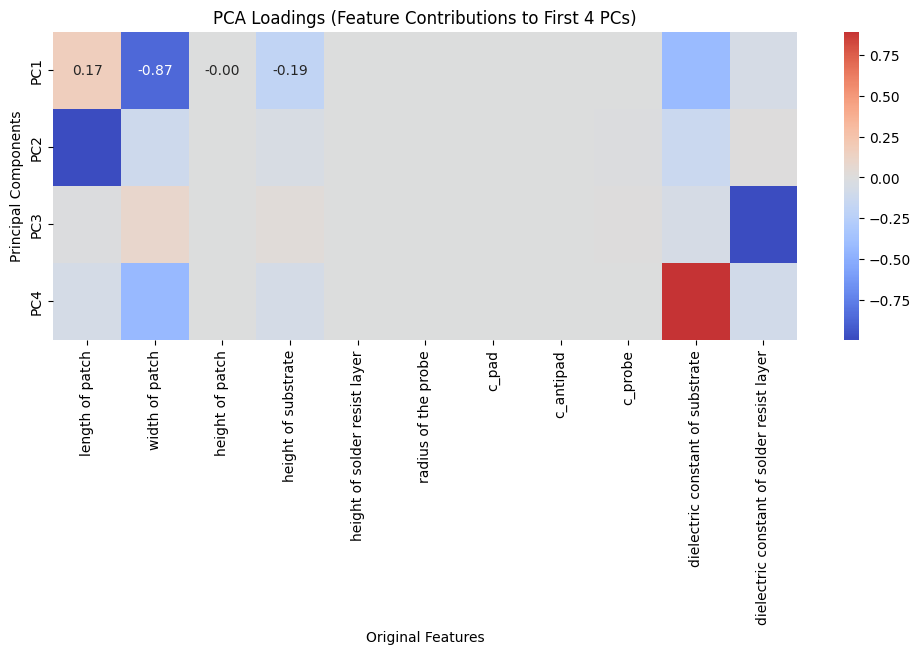

In [8]:
n_components = 4 # Selected number of components
pca_components = pca.components_[:n_components, :]

# Information of each feature on each PCA components
loadings_df = pd.DataFrame(pca_components, 
                            columns=feature_names,
                            index=[f'PC{i+1}' for i in range(n_components)])

# Heatmap of informations on PCA components with real features
plt.figure(figsize=(12, 4))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('PCA Loadings (Feature Contributions to First 4 PCs)')
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.show()

- From above heatmap, we can see that some of the geometric features are affected first 4 PCA components such as `length of patch`, `width of patch` or `dielectric constant of solder resist layer`
- On the other hand some features has not used on PCA components such as `c_pad`, `c_antipad` or `c_probe`

Also in order to chech whether PCA components has correlation with S11 parameters, Below there is correlation matrix of first 4 PCA components with S11 parameters.

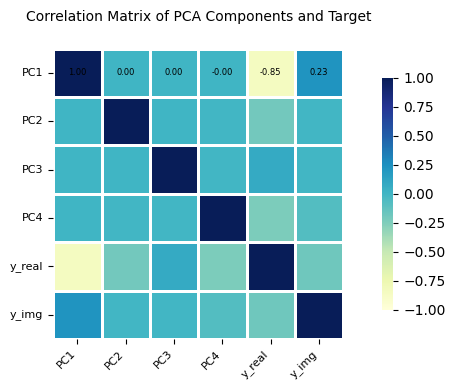

In [9]:
pca_components = pca.transform(X)[:, :4]
pca_components = pd.DataFrame(pca_components, columns=[f'PC{i+1}' for i in range(4)])

pca_components['y_real'] = y_real
pca_components['y_img'] = y_img
pca_correlations = pca_components.corr()

plt.figure(figsize=(8, 4))
sns.heatmap(pca_correlations, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=1, cbar_kws={"shrink": 0.8}, 
            annot_kws={"size": 6, "color": "black"}, 
            square=True, vmin=-1, vmax=1, cbar=True)
plt.title('Correlation Matrix of PCA Components and Target', fontsize=10, pad=20)
plt.xticks(fontsize=8, rotation=45, ha='right')
plt.yticks(fontsize=8, rotation=0)
plt.tight_layout()
plt.show()

- From above correlation matrix, as we aspect, first components of PCA has more correlation than others. Even though PC2 and PC4 seems very close correlation with real part of S11 parameter
- For imaginary part of S11, PCA components seem less correlated. This can lead that probably the model we trained for imaginary part with this PCA components perform poorer respectively

#### PCA with Standardized Data

- Below our data standardized with `StandardScaler`, where it scale all the features on the same scale with 0 mean and 1 standard deviation.
- And then, we perform PCA again with that dataset.

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

feature_name_list = features.columns.to_list()
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_name_list)

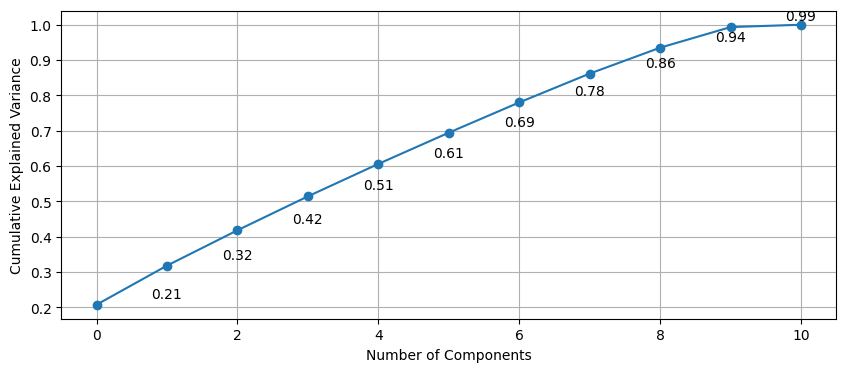

Cumulative Variances: [0.20715348 0.31786173 0.41789557 0.51396794 0.60583873 0.69429699
 0.77995603 0.86160656 0.93500519 0.99330787 1.        ]


In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_scaled = PCA()
pca_scaled.fit(X_scaled)

cumulative_variance_scaled = np.cumsum(pca_scaled.explained_variance_ratio_)

plt.figure(figsize=(10, 4))
plt.plot(cumulative_variance_scaled, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
for i, value in enumerate(cumulative_variance_scaled):
    plt.annotate(f"{value:.2f}", (i + 1, value), textcoords="offset points", xytext=(0, 5), ha='center')
plt.show()

print("Cumulative Variances:", cumulative_variance_scaled)

- With checking cumulative variances, 93% of total variance can be represented by 9 components of PCA
- That is why we can continue with 9 components of PCA. Because we reached enough information. We will continue with using first 9 components of our PCA.
- This one is more reliable PCA because dataset is standardized and it is expected to perform better. Even though it is not depreciate dimensionality of our problem. While we have 11 features in the beginning, PCA able to reduce to 9 only

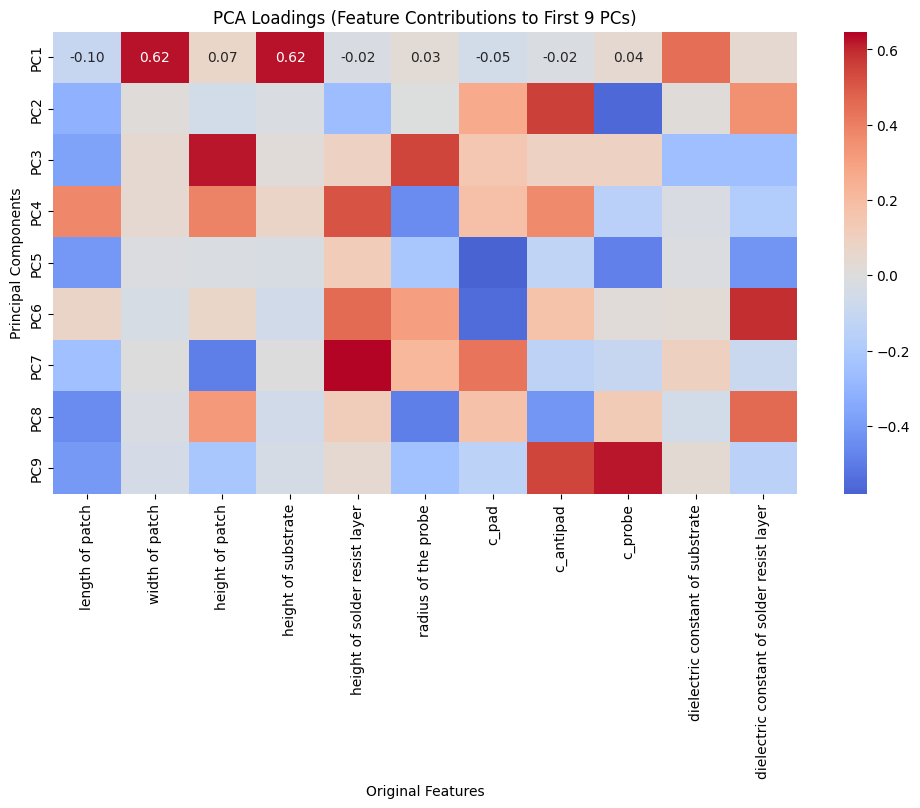

In [12]:
n_components = 9 # Selected number of components
pca_scaled_components = pca_scaled.components_[:n_components, :]

# Information of each feature on each PCA components
scaled_loadings_df = pd.DataFrame(pca_scaled_components, 
                            columns=feature_names,
                            index=[f'PC{i+1}' for i in range(n_components)])

# Heatmap of informations on PCA components with real features
plt.figure(figsize=(12, 6))
sns.heatmap(scaled_loadings_df, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('PCA Loadings (Feature Contributions to First 9 PCs)')
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.show()

- From above heatmap, we can see that all features are represented somehow in selected PC's. However, some of the features are started to represented in later PC's. For example, `width of patch` has information on PC1, on the other hand, `radius o the probe` started to represented in PC3.

Also in order to chech whether Scaled Data PCA components has correlation with S11 parameters, Below there is correlation matrix of first 9 PCA components with S11 parameters.

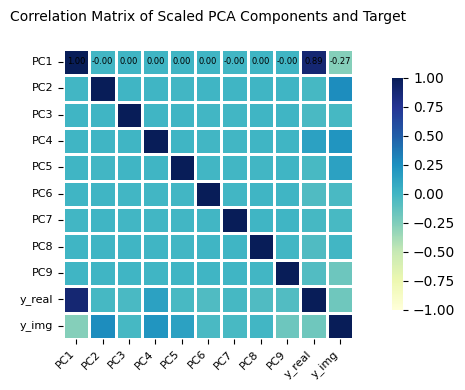

In [13]:
pca_scaled_components = pca_scaled.transform(X_scaled)[:, :9]
pca_scaled_components = pd.DataFrame(pca_scaled_components, columns=[f'PC{i+1}' for i in range(9)])

pca_scaled_components['y_real'] = y_real
pca_scaled_components['y_img'] = y_img
pca_scaled_correlations = pca_scaled_components.corr()

plt.figure(figsize=(8, 4))
sns.heatmap(pca_scaled_correlations, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=1, cbar_kws={"shrink": 0.8}, 
            annot_kws={"size": 6, "color": "black"}, 
            square=True, vmin=-1, vmax=1, cbar=True)
plt.title('Correlation Matrix of Scaled PCA Components and Target', fontsize=10, pad=20)
plt.xticks(fontsize=8, rotation=45, ha='right')
plt.yticks(fontsize=8, rotation=0)
plt.tight_layout()
plt.show()

- From above correlation matrix, as we aspect, first components of PCA has more correlation than others. It can be seen that while the index of PC increases correlation with S11 parameters decreases which is expected situation because first PC's have more informations included.
- Like the first version of PCA also in this Scaled Data PCA, for imaginary part of S11, PCA components seem less correlated

### Q3.2 - Regression Modelling

- Started with training linear regression models in order to predict both real and imaginary seperately.
- 3 different set is used
    - PCA components without standardization of data (4 components)
    - PCA components with standardization of data (9 components)
    - Base geometric features (11 geometric feature)
- From those three set, we can find the best performed models and continue with more sophisticated regression models (XGBoost, LightGBM etc.)

#### *Linear Regression (LR) for Real Part of S11*

- Using PCA (Non-Standardized) Components

In [14]:
# Data Prep
pca_comp = pca_components.drop(columns=['y_img', 'y_real'])
X_train, X_test, y_train, y_test = train_test_split(pca_comp, y_real, test_size=0.2, random_state=45)

# Model Training 
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Performance Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Coefficients
coefficients_df = pd.DataFrame({
    'Feature': list(X_train.columns),
    'Coefficient': lr.coef_
})
coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)

#Outputs
print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')
print("\nCoefficients for each feature:")
print(coefficients_df.to_string(index=False))

Mean Squared Error: 0.03
R-squared: 0.84

Coefficients for each feature:
Feature  Coefficient
    PC1    -0.301309
    PC4    -0.155122
    PC2    -0.098910
    PC3     0.042685


- Using PCA (Standardized) Components

In [15]:
# Data Prep
pca_scaled_comp = pca_scaled_components.drop(columns=['y_img', 'y_real'])
X_train, X_test, y_train, y_test = train_test_split(pca_scaled_comp, y_real, test_size=0.2, random_state=45)

# Model Training 
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Performance Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Coefficients
coefficients_df = pd.DataFrame({
    'Feature': list(X_train.columns),
    'Coefficient': lr.coef_
})
coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)

#Outputs
print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')
print("\nCoefficients for each feature:")
print(coefficients_df.to_string(index=False))

Mean Squared Error: 0.03
R-squared: 0.85

Coefficients for each feature:
Feature  Coefficient
    PC1     0.274403
    PC4     0.063782
    PC9    -0.037715
    PC8    -0.031805
    PC6    -0.023111
    PC7    -0.015829
    PC3    -0.013993
    PC5    -0.012583
    PC2    -0.009959


- Using Geometric Features

In [16]:
# Data Prep
X_train, X_test, y_train, y_test = train_test_split(X, y_real, test_size=0.2, random_state=45)

# Model Training
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Performance Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Coefficients
coefficients_df = pd.DataFrame({
    'Feature': list(X_train.columns),
    'Coefficient': lr.coef_
})
coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)

#Outputs
print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')
print("\nCoefficients for each feature:")
print(coefficients_df.to_string(index=False))

Mean Squared Error: 0.01
R-squared: 0.93

Coefficients for each feature:
                                   Feature  Coefficient
                       radius of the probe    -3.073623
                       height of substrate     1.594663
                           height of patch    -0.511309
                                 c_antipad     0.169192
             height of solder resist layer     0.152388
                                   c_probe    -0.138393
          dielectric constant of substrate    -0.038416
                           length of patch     0.035481
                            width of patch     0.030124
                                     c_pad     0.023951
dielectric constant of solder resist layer     0.005793


- From those three models that predicts real part of S11, the data without PCA out perform PCA components both.

#### *Linear Regression (LR) for Imaginary Part of S11*

- Using PCA (Non-Standardized) Components

In [17]:
# Data Prep
X_train, X_test, y_train, y_test = train_test_split(pca_comp, y_img, test_size=0.2, random_state=45)

# Model Training
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Performance Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Coefficients
coefficients_df = pd.DataFrame({
    'Feature': list(X_train.columns),
    'Coefficient': lr.coef_
})
coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)

#Outputs
print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')
print("\nCoefficients for each feature:")
print(coefficients_df.to_string(index=False))

Mean Squared Error: 0.13
R-squared: 0.10

Coefficients for each feature:
Feature  Coefficient
    PC1     0.051935
    PC4    -0.043565
    PC2     0.007419
    PC3    -0.007189


- Using PCA (Standardized) Components

In [18]:
# Data Prep
pca_scaled_comp = pca_scaled_components.drop(columns=['y_img', 'y_real'])
X_train, X_test, y_train, y_test = train_test_split(pca_scaled_comp, y_img, test_size=0.2, random_state=45)

# Model Training
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Performance Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Coefficients
coefficients_df = pd.DataFrame({
    'Feature': list(X_train.columns),
    'Coefficient': lr.coef_
})
coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)

#Outputs
print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')
print("\nCoefficients for each feature:")
print(coefficients_df.to_string(index=False))

Mean Squared Error: 0.13
R-squared: 0.11

Coefficients for each feature:
Feature  Coefficient
    PC2     0.112633
    PC4     0.087627
    PC5     0.060868
    PC9    -0.060369
    PC1    -0.057126
    PC3    -0.015708
    PC7    -0.010369
    PC6    -0.009444
    PC8    -0.007223


- Using Geometric Features

In [19]:
# Data Prep
X_train, X_test, y_train, y_test = train_test_split(X, y_img, test_size=0.2, random_state=45)

# Model Training
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Performance Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Coefficients
coefficients_df = pd.DataFrame({
    'Feature': list(X_train.columns),
    'Coefficient': lr.coef_
})
coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)

#Outputs
print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')
print("\nCoefficients for each feature:")
print(coefficients_df.to_string(index=False))

Mean Squared Error: 0.12
R-squared: 0.15

Coefficients for each feature:
                                   Feature  Coefficient
                       radius of the probe    -4.994575
                           height of patch     2.918317
                                 c_antipad     2.645162
                                     c_pad     2.639878
                                   c_probe    -1.305260
                       height of substrate    -0.701528
             height of solder resist layer     0.398507
                            width of patch     0.118025
          dielectric constant of substrate    -0.039165
                           length of patch     0.024334
dielectric constant of solder resist layer    -0.005607


From all those models trained, we can conclude that,
- For both part of S11 (real and imaginary), while PCA components do dimensionality reduction, it loose some information from data and it perform poorer that original set.
- Real part of S11 can more predictable with provided data set (Basic LR model performance is around 0.90 R^2 value). That is why, it can be said that geometric shapes of antenna can be usable for predict real part of S11. 
- However, attention should be paid while getting predictions (Basic LR model performance is around 0.15 R^2 value) for imaginary part of S11 from geometric shapes of antenna

It can be continued with more sophisticated regression models with using geometric features in order to increase our prediction performances

#### XGBoost and LigthGBM Attemps

XGBoost and LightGBM are gradient boosting machines that are useful for regresssion tasks. I tried both of them in our dataset to see whether they are perform better than basic Linear Regressions

##### Training Models for Real part of S11

In [20]:
#XGBoost
#Data Prep
X_train_prep, X_test, y_train_prep, y_test = train_test_split(X, y_real, test_size=0.2, random_state=45)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_prep, y_train_prep, test_size=0.1, random_state=45)

# Modelling
X_train, X_test, y_train, y_test = train_test_split(X, y_real, test_size=0.2, random_state=45)
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=45)
xgboost_model.fit(X_train, y_train)
y_pred_xgb = xgboost_model.predict(X_test)

# Performance Metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'Mean Squared Error: {mse_xgb:.2f}')
print(f'R-squared: {r2_xgb:.2f}')

/home/jovyan/.local/lib/python3.11/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Mean Squared Error: 0.00
R-squared: 0.97


In [21]:
# LightGBM
# Modelling
lgb_model = lgb.LGBMRegressor(
    
    n_jobs = -1,
    random_state = 45,
    metric = "l2",
    verbose = -1,
    
    objective = 'regression',
    boosting_type = 'gbdt',
    num_leaves = 31,
    learning_rate = 0.05,
    feature_fraction = 0.9,
)
lgb_model.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_validation, y_validation)],
    eval_metric= "l2",
    callbacks=[lgb.early_stopping(stopping_rounds=50),lgb.log_evaluation(-1)]
)

# Performance Metrics
y_pred_lgb = lgb_model.predict(X_test)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f'Mean Squared Error: {mse_lgb:.2f}')
print(f'R-squared: {r2_lgb:.2f}')

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00244855
Mean Squared Error: 0.01
R-squared: 0.96


- Visualization of Predictions

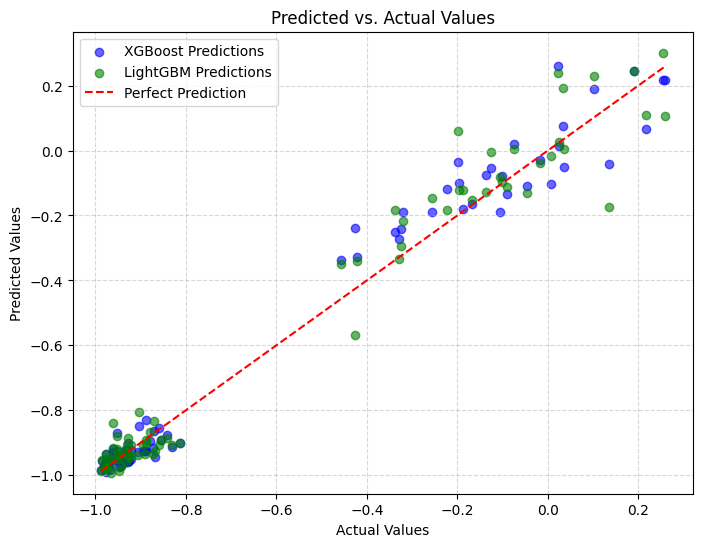

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, color='blue', alpha=0.6, label='XGBoost Predictions')
plt.scatter(y_test, y_pred_lgb, color='green', alpha=0.6, label='LightGBM Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

- It can be seen from both visualization of predictions and R^2 performance metric, gradient boosting models are out perform linear regression as expected. 
- Also we can conclude that with using geometric shapes of antenna, real part of S11 can be predictable

##### Training Models for Imaginary part of S11

In [23]:
# XGBoost
# Data Prep
X_train_prep, X_test, y_train_prep, y_test = train_test_split(X, y_img, test_size=0.2, random_state=45)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_prep, y_train_prep, test_size=0.1, random_state=45)

# Modelling
X_train, X_test, y_train, y_test = train_test_split(X, y_img, test_size=0.2, random_state=45)
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=45)
xgboost_model.fit(X_train, y_train)
y_pred_xgb = xgboost_model.predict(X_test)

# Performance Metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'Mean Squared Error: {mse_xgb:.2f}')
print(f'R-squared: {r2_xgb:.2f}')

/home/jovyan/.local/lib/python3.11/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Mean Squared Error: 0.10
R-squared: 0.29


In [24]:
# LightGBM
# Modelling
lgb_model = lgb.LGBMRegressor(
    
    n_jobs = -1,
    random_state = 45,
    metric = "l2",
    verbose = -1,
    
    objective = 'regression',
    boosting_type = 'gbdt',
    num_leaves = 31,
    learning_rate = 0.05,
    feature_fraction = 0.9,
)
lgb_model.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_validation, y_validation)],
    eval_metric= "l2",
    callbacks=[lgb.early_stopping(stopping_rounds=50),lgb.log_evaluation(-1)]
)
# Performance Metrics
y_pred_lgb = lgb_model.predict(X_test)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f'Mean Squared Error: {mse_lgb:.2f}')
print(f'R-squared: {r2_lgb:.2f}')

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00946352
Mean Squared Error: 0.09
R-squared: 0.33


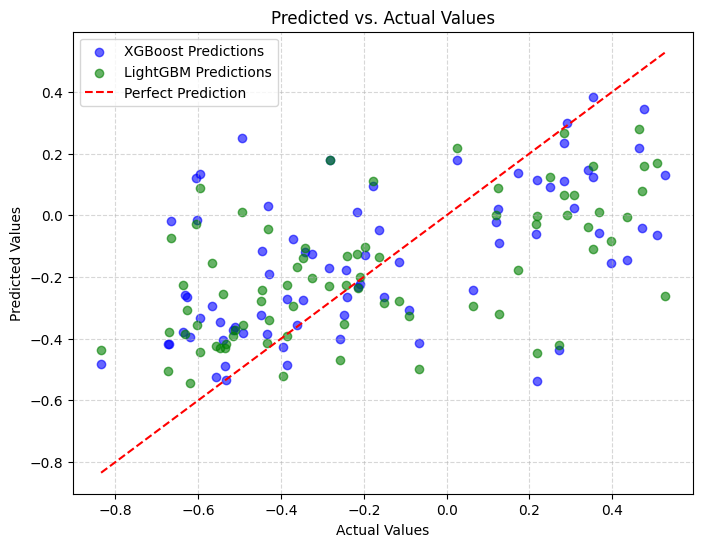

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, color='blue', alpha=0.6, label='XGBoost Predictions')
plt.scatter(y_test, y_pred_lgb, color='green', alpha=0.6, label='LightGBM Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

- It can be seen from both visualization of predictions and R^2 performance metric, gradient boosting models are out perform linear regression as expected. 
- In contrast with real part, predicting imaginary part of S11 with geometric shapes of antenna is not trustworthy. The model performance can be increased with hyper paramater tuning, however the performance probably can't reach desired level.

### Q3.3 Model Performances and Interpretations

**PCA Performance**:
- It can easily seen that while PCA components are reducing dimension of the problem, the models created from them is not perform well. This happened because of this reason, as we mentioned above in part of PCA Analysis, features in our dataset are not normally distributed and PCA work well on normally distributed data.
- If we still need to do PCA, we can do preprocessing / transformation techniques for skewed data, or we can use Kernel PCA.

**Regression Models Performance**:
- Regression models are worked very well while predicting real part of S11. Even tough, there are relatively small dataset (385 design) we have, still models can learnt how to predict the target value
- However, this dataset was not enough to predict imaginary part of S11.
    - This situation can be overcome with adding more design into dataset, so models can learn from more dataset with more robust predictions.
    - Also with literature review, it can be added more geometric shapes as feature that has a role to change imaginary part of S11.
    - It can be done some non-linear operations on given feature set, because we did not focused on design of antenna, we did not create different types of features from given features. For example with using `radius of the probe`, it can be calculated area of the circle. This could represent a piece of information while predicting S11 parameter and increase model performances.